In [1]:
import sys
sys.path.append("../../backend")

import requests
from io import BytesIO
from PIL import Image
from image_classifier import ImageClassifier

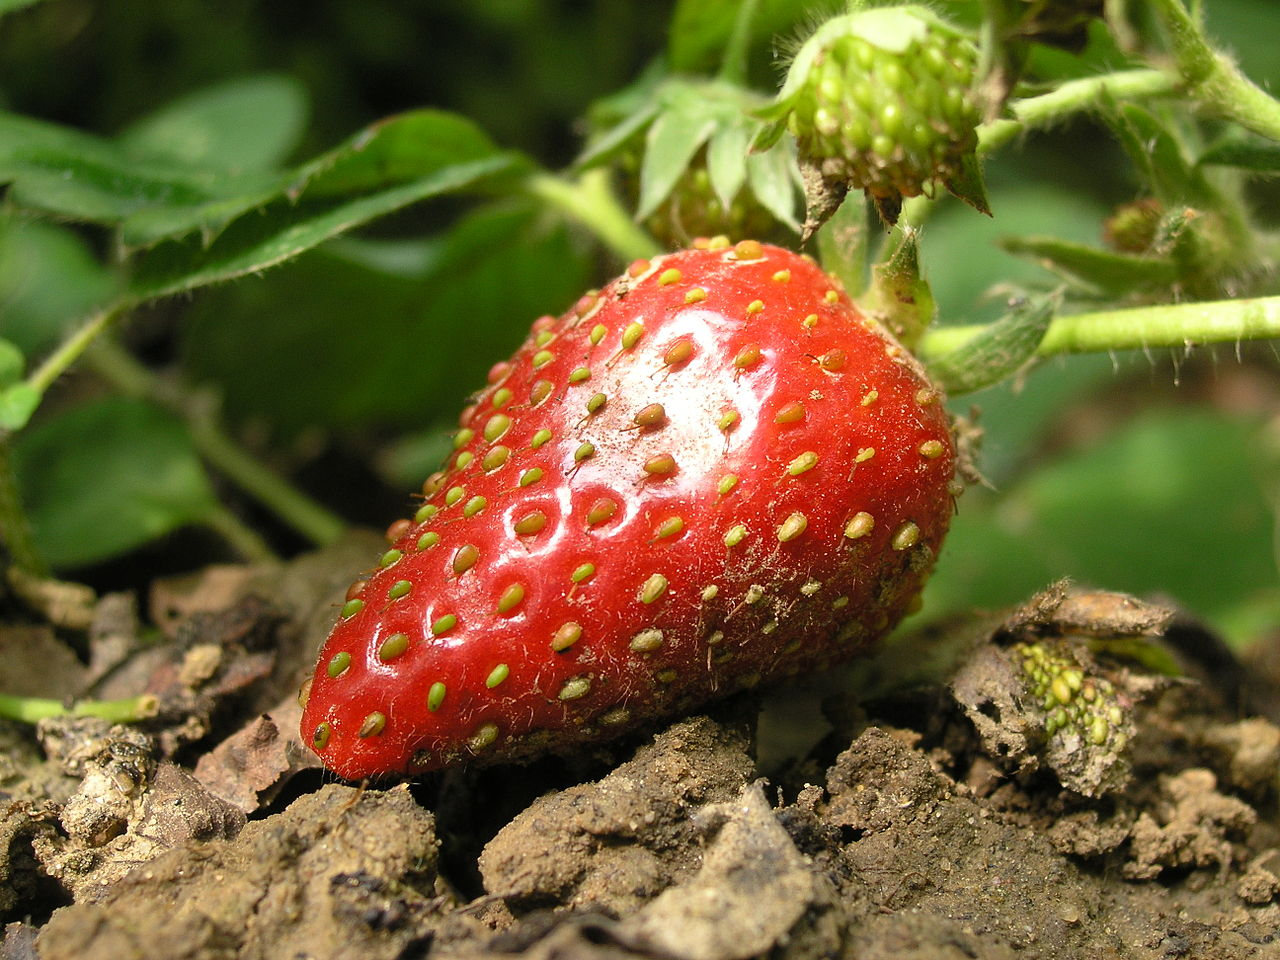

In [2]:
response = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Erste-Erdbeere.jpg/1280px-Erste-Erdbeere.jpg")
img = Image.open(BytesIO(response.content))
img

In [3]:
classifier = ImageClassifier()
classifier.classify(img)

[('strawberry', 99.99625396728516),
 ('pineapple', 0.0012453702511265874),
 ('agaric', 0.0004832521954085678),
 ('trifle', 0.0002870271564461291),
 ('chocolate_sauce', 0.00021906834444962442)]